In [1]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Load Data and Explore

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 118901892.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 81848441.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32870362.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15326250.01it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

In [5]:
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


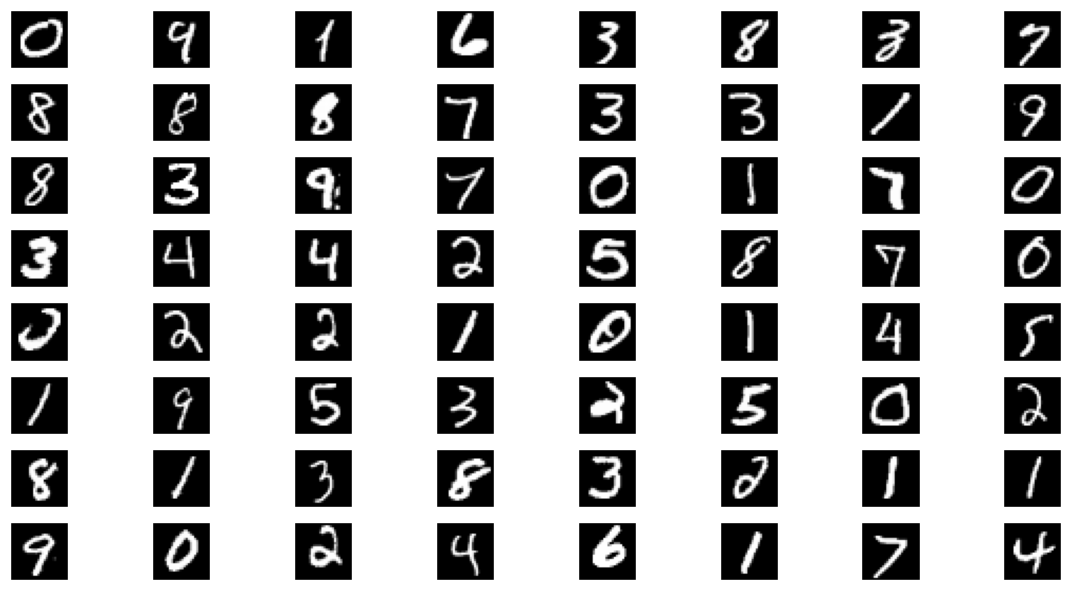

In [6]:
def display_images(images, n_cols=4, figsize=(12, 6)):
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=8)

### Discriminator Network

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # Rehape passed image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        logit_out = self.fc4(x)

        return logit_out

### Generator Network

In [8]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features


        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()


    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)

        return tanh_out

## Define Losses

In [9]:
def real_loss(predicted_outputs, loss_fn, device):

    batch_size = predicted_outputs.shape[0]

    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):

    batch_size = predicted_outputs.shape[0]
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return fake_loss

## Train the network
Discriminator and Generator will be trained together we need separate optimizer for them

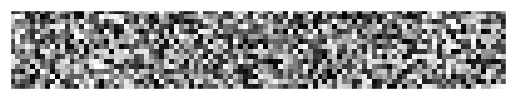

In [10]:
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:

def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)
    fixed_samples = []
    d_losses = []
    g_losses = []


    d = d.to(device)
    g = g.to(device)

    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')

        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):

            real_images = real_images.to(device)

            d_optim.zero_grad()

            real_images = (real_images * 2) - 1
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            with torch.no_grad():

                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)

                fake_images = g(z)

            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)

            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_optim.step()

            d_running_batch_loss += d_loss


            g_optim.zero_grad()

            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)

            fake_images = g(z)
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)

            g_loss.backward()
            g_optim.step()

            g_running_batch_loss += g_loss

            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')

        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)

        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')

        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())

    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses

In [12]:
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
print(d)
print()
print(g)

d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

loss_fn = nn.BCEWithLogitsLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim,
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/100]:
epoch_d_loss: 1.135265 	epoch_g_loss: 1.703524
Epoch [2/100]:
epoch_d_loss: 1.08

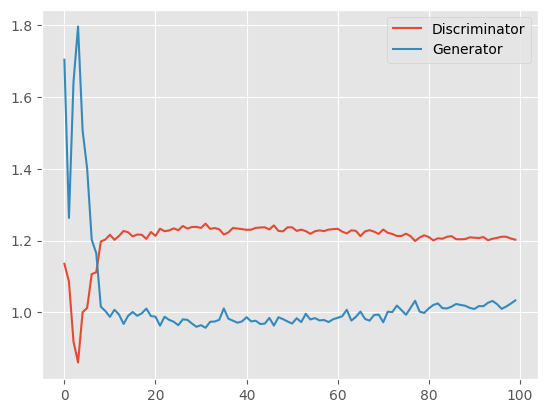

In [14]:

plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [15]:
def show_generated_images(epoch, n_cols=8):

    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]

    epoch_data = (epoch_data + 1) / 2

    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

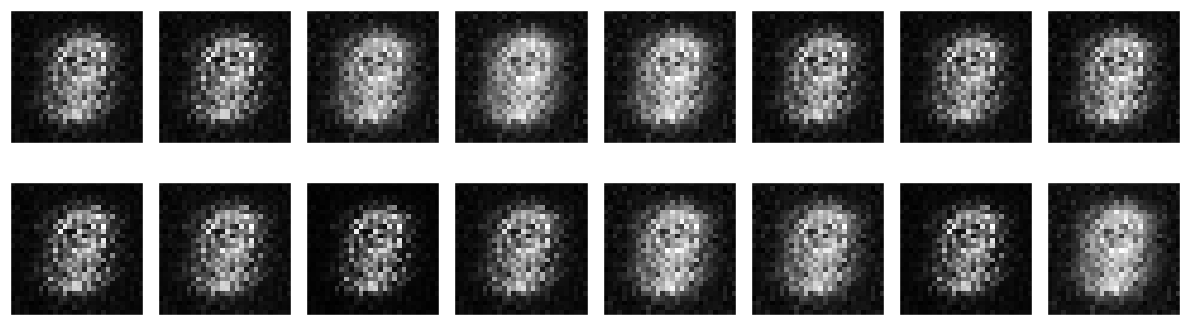

In [16]:
show_generated_images(epoch=1, n_cols=8)

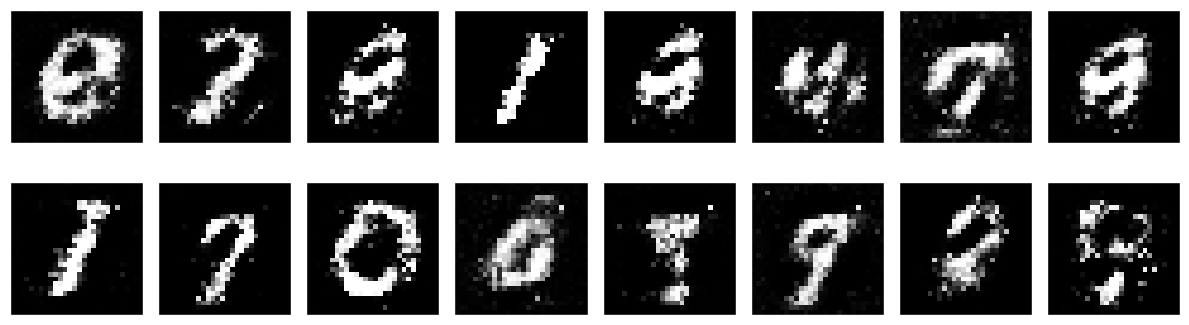

In [17]:
show_generated_images(epoch=10, n_cols=8)

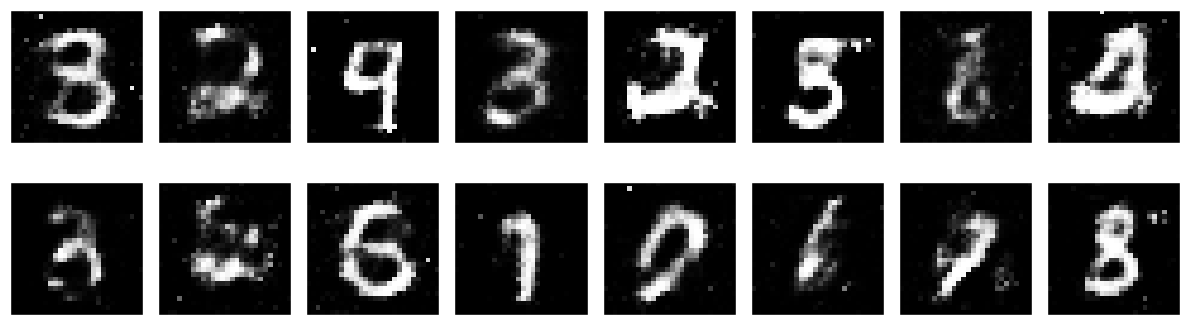

In [18]:
show_generated_images(epoch=50, n_cols=8)

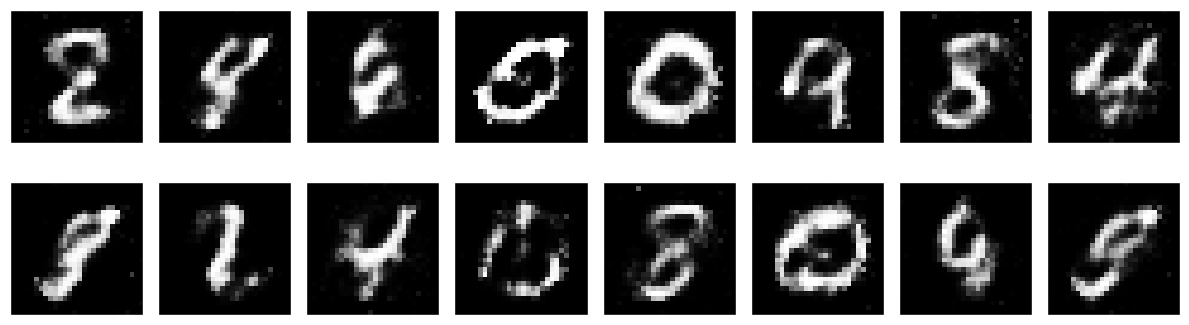

In [19]:
show_generated_images(epoch=100, n_cols=8)

## Test the network
The trained generator can be used to generate a fake random digit that'd look like as if it came from MNIST dataset.
Discriminator can be discarded now.

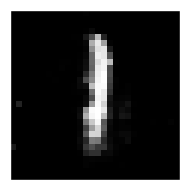

In [21]:

g.to('cpu')
g.eval()

z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))